In [1]:
### Let's build a convolutional neural network for the 3-label classification ###

In [2]:
# import modules
import pandas as pd
import numpy as np
import cv2 as cv
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils, to_categorical
from keras.optimizers import Adam
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

2023-01-14 14:48:52.433108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 14:48:53.355403: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ricardo/Documents/MEB/AA/aaenv/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-14 14:48:53.355499: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ricardo/Documents/MEB/AA/aaenv/lib/python3.8/si

In [3]:
### Load the 3-class dataset
data = pd.read_csv('../fifty_neither_vs_mel_keratosis_features_targets.csv')
data

,image_id,green_iqr,blue_iqr,original_firstorder_Entropy,original_glcm_Autocorrelation,original_glcm_Imc1,original_glcm_Imc2,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_ngtdm_Complexity,original_ngtdm_Strength,melanoma,seborrheic_keratosis,neither
0,ISIC_0000001,58,40,1.163592,6.023905,-0.403236,0.770104,4.672684,0.974713,0.299423,2.777913,0.808480,0.124740,0,0,1
1,ISIC_0000002,52,67,0.112792,3.988779,-0.564990,0.250990,5.051852,1.278172,0.380191,1.932127,0.007574,0.941026,1,0,0
2,ISIC_0000004,44,55,2.589392,31.008519,-0.770726,0.988910,4.673329,0.806039,0.268533,4.275156,3.153283,2.213424,1,0,0
3,ISIC_0000006,76,101,0.440230,1.211871,-0.222705,0.401163,4.594168,4.418287,1.346867,2.115149,0.049819,0.046243,0,0,1
4,ISIC_0000009,60,58,0.988476,2.683550,-0.541114,0.806245,4.652174,2.641480,0.819539,2.553233,0.065349,0.021467,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309,ISIC_0015220,47,51,1.713805,6.160656,-0.803562,0.964020,7.478586,2.277177,5.152584,4.435975,0.271341,0.070004,0,1,0
1310,ISIC_0015233,73,59,1.192893,7.055527,-0.746103,0.909626,5.027475,0.864552,0.267658,3.028206,0.237932,0.042187,0,1,0
1311,ISIC_0015260,51,34,1.184338,4.310333,-0.629008,0.887234,7.512658,2.805714,5.593992,4.190389,0.904079,0.132170,0,1,0
1312,ISIC_0015284,76,85,2.421955,16.197648,-0.811300,0.988714,5.205730,0.730521,0.553786,4.160087,2.045905,0.333450,1,0,0


In [4]:
# diagnostic column:
## 0 - neither, 1 - melanoma, 2 - seborrheic keratosis, 
for i,u in enumerate(data['image_id']):
    if data.loc[i,'melanoma'] == 0:
        if data.loc[i,'seborrheic_keratosis'] == 1:
            data.loc[i,'melanoma'] = 2
    else:
        continue      
data.drop(columns=['seborrheic_keratosis', 'neither'], inplace=True)

In [5]:
targets = pd.DataFrame(data[['image_id','melanoma']])

In [6]:
targets

,image_id,melanoma
0,ISIC_0000001,0
1,ISIC_0000002,1
2,ISIC_0000004,1
3,ISIC_0000006,0
4,ISIC_0000009,0
...,...,...
1309,ISIC_0015220,2
1310,ISIC_0015233,2
1311,ISIC_0015260,2
1312,ISIC_0015284,1


In [7]:
## Get images array and add to DataFrame
## image array shape (image, width, height, rgb)

path = '../../segmented/SEG'
X = []
Y = []
for i in targets['image_id']:
    clear_output(wait=True)
    impath = path + i + '.jpg'
    im = cv.imread(impath, -1)
    im_rgb = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    # augment data through flipping
    im_flipped_0 = cv.flip(im_rgb,0)
    X.append(im_rgb)
    Y.append(targets[targets['image_id']==i]['melanoma'].item())
  
    X.append(im_flipped_0)
    Y.append(targets[targets['image_id']==i]['melanoma'].item())

    
    
    
    

../../segmented/SEGISIC_0015295.jpg
(150, 150, 3)


In [8]:
X = np.array(X)
np.shape(X)

(2628, 150, 150, 3)

In [10]:
# [1., 0., 0.] - neither, [0., 1., 0.] melanoma, [0., 0., 1.] keratosis
Y = to_categorical(Y, num_classes=3)
Y

# normalize pixel values
X = (X-127.5) / 127.5

In [11]:
# Neural network structure

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 146, 146, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 146, 146, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 50)        40050     
                                                                 
 batch_normalization_1 (Batc  (None, 69, 69, 50)       200       
 hNormalization)                                                 
                                                        

2023-01-14 14:48:58.618577: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ricardo/Documents/MEB/AA/aaenv/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-14 14:48:58.618619: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-14 14:48:58.618981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other op

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1)

In [13]:
optimizer = Adam(lr=0.001)

/home/ricardo/Documents/MEB/AA/aaenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['acc'])

Epoch 1/5
237/237 [==============================] - 164s 688ms/step - loss: 6.5002 - acc: 0.4867 - val_loss: 211.2310 - val_acc: 0.4563
Epoch 2/5
237/237 [==============================] - 163s 686ms/step - loss: 1.0123 - acc: 0.5252 - val_loss: 1056.0369 - val_acc: 0.2471
Epoch 3/5
237/237 [==============================] - 163s 689ms/step - loss: 1.0123 - acc: 0.5239 - val_loss: 490.2979 - val_acc: 0.3954
Epoch 4/5
237/237 [==============================] - 164s 694ms/step - loss: 1.0107 - acc: 0.5243 - val_loss: 493.5303 - val_acc: 0.4183
Epoch 5/5
237/237 [==============================] - 168s 708ms/step - loss: 1.0109 - acc: 0.5247 - val_loss: 342.7300 - val_acc: 0.4183


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


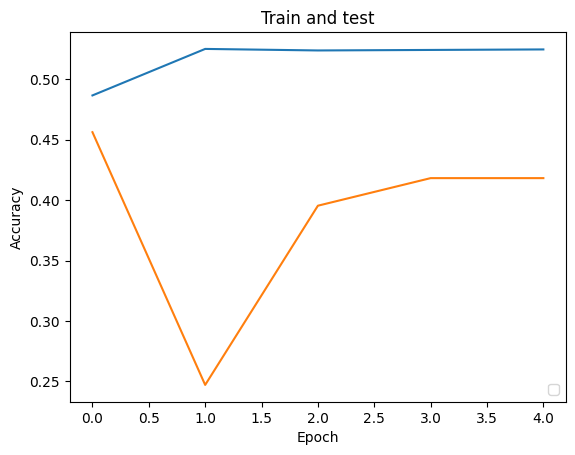

In [15]:
h = model.fit(X_train, y_train, batch_size=10, epochs=5, validation_data=(X_test, y_test))

plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title("Train and test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')